# 순환신경망의 이해   
   **(RNN : Recurrent Neural Network)** 

**cf) 기존의 신경망 모형**
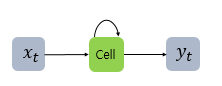

기존의 신경망의 경우, 은닉층 노드에서 활성화 함수를 통해 나온 결과값은 활성화 함수를 거쳐 출력되고, error값을 통해 가중치를 수정해주는 방식 (피드 포워드 신경망 (feed forward neural network) ) 

* 순환 신경망의 기본적 개념 
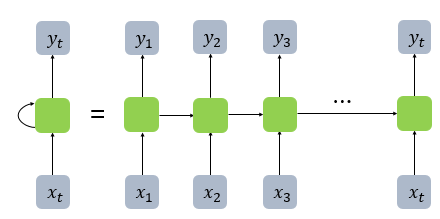

그림과 같이 RNN 계열의 신경망은 은닉층의 노드에서 활성화 함수를 통해 나온 결과값을 출력층 방향으로도 보내면서, 다시 은닉층 노드의 다음 계산의 입력으로 보내는 특징을 갖고있다.

**x** : 입력층의 입력 벡터  
**b** : 편향  
**cell(셀)** :: 은닉층에서 활성롸 함수를 거쳐 결과를 내보내는 역할을 하는 노드를 의미함  
**메모리 셀** :: (RNN 셀 이라고도 불림.) 이전의 값을 기억하려 하는 일종의 메모리 역할을 수행  

은닉층의 각 메모리셀은 각각의 시점에서 바로 이전시점에서의 은닉층의 메모리 셀에서 나온 값을 자신의 입력으로 사용하는 재귀적 활동을 수행함  

메모리 셀이 출력층 방향으로 또는 다음 시점 t+1의 자신에게 보내는 값을 **은닉 상태(hidden state)** 라고 합니다. 다시 말해 t 시점의 메모리 셀은 t-1 시점의 메모리 셀이 보낸 은닉 상태값을 t 시점의 은닉 상태 계산을 위한 입력값으로 사용합니다.

* RNN의 수식적 정리 
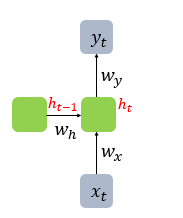

**h_t** : 현재 시점(t)에서의 은닉상태 값  
* 은닉층의 메모리셀은 h_t를 계산하기 위해 총 두가지의 가중치를 갖게 된다.  
1. W_x : 입력층에서 들어오는 입력 값을 취합하기 위한 가중치  
2. W_h : 이전 시점의 은닉상태값인 h_(t-1)의 정보를 변수로 받기 위한 가중치

은닉층 : **h_t = tanh(W_x * X_t +W_h * h_(t-1) + b)**
출력층 : **y_t = f(W_y * h_t + b)**  
        (단 , 출력층의 f는 비선형 활성화 함수 중 하나이다.) 

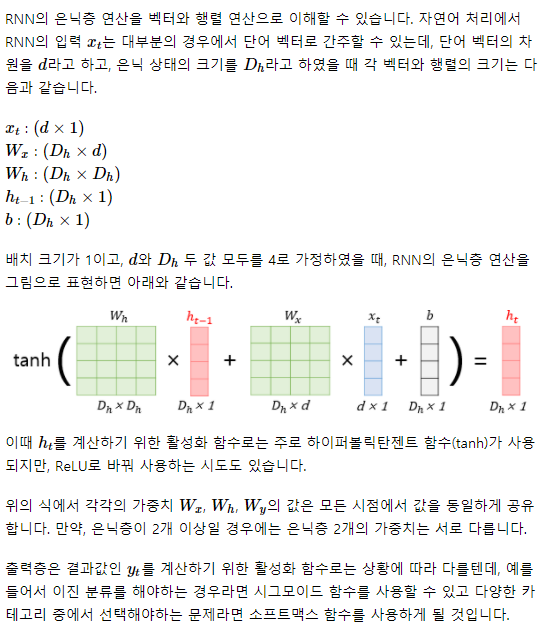

## 파이썬으로 직접 RNN 구현하기 

직접 Numpy로 RNN 층을 구현해보겠습니다. 앞서, 메모리 셀의 은닉상태를 계산하는 식을 다음과 같이 정의 했었음
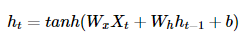
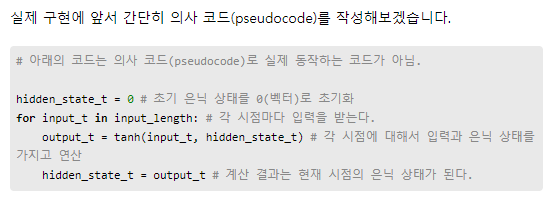
우선 t 시점의 은닉 상태를 hidden_state_t라는 변수로 선언하였고, 입력 데이터의 길이를 input_length로 선언하였습니다. 이 경우, 입력 데이터의 길이는 곧 총 시점의 수(timesteps)가 됩니다. 그리고 t 시점의 입력값을 input_t로 선언하였습니다. 각 메모리 셀은 각 시점마다 input_t와 hidden_sate_t(이전 상태의 은닉 상태)를 입력으로 활성화 함수인 하이퍼볼릭탄젠트 함수를 통해 현 시점의 hidden_state_t를 계산합니다.

의사 코드를 통해 간단히 개념 정립을 해보았습니다. 이제 RNN 층을 실제 동작되는 코드로 구현해보겠습니다. 아래의 코드는 이해를 돕기 위해 (timesteps, input_size) 크기의 2D 텐서를 입력으로 받았다고 가정하였으나, 실제로 파이토치에서는 (batch_size, timesteps, input_size)의 크기의 3D 텐서를 입력으로 받는 것을 기억합시다.

In [1]:
import numpy as np 

time_steps = 10 # 데이터의 시점의 수, 그니까 덩어리가 10개 있다~ 
input_size = 4 # 입력 벡터의 차원 # 즉, 한개의 행에 4개의 열, 원소가 있다. 
hidden_size = 8 # 은닉 상태의 크기, 메모리셀의 용량 --? 

inputs = np.random.random((time_steps, input_size)) # 입력으로 들어갈 2D 텐서 생성(말이 텐서지 우리가 보던 행렬꼴의 배열) 

hidden_state_t = np.zeros((hidden_size,)) # 초기 은닉상태를 0백터로 집어 넣어줄것임 

In [2]:
inputs

array([[0.39126457, 0.05722793, 0.8262807 , 0.5613554 ],
       [0.61155343, 0.80842623, 0.9644593 , 0.36865023],
       [0.71819841, 0.1280615 , 0.19565904, 0.78039458],
       [0.91248435, 0.96485216, 0.97125848, 0.48266113],
       [0.25045104, 0.45366805, 0.11697271, 0.31217487],
       [0.10005175, 0.07365768, 0.80455319, 0.32993488],
       [0.94019141, 0.27606992, 0.9503017 , 0.66576917],
       [0.45824569, 0.8996106 , 0.75776908, 0.27475553],
       [0.67793142, 0.71343754, 0.36604804, 0.78557789],
       [0.66505912, 0.38197635, 0.64988461, 0.79616212]])

In [3]:
hidden_state_t

array([0., 0., 0., 0., 0., 0., 0., 0.])

* 가중치와 편향을 정의한다 

In [4]:
# 입력벡터에 대한 가중치 
Wx = np.random.random((hidden_size,input_size)) # 입력벡터와 곱해준 값의 차원이 (hidden_Size X 1) 이어야 하기 때문에 다음과 같이 정의해줍니다. 

# 은닉상태에 대한 가중치 
Wh = np.random.random((hidden_size,hidden_size)) 
# (8 x 1) 차원의 히든 값이 나오면 --> 가중치를 주고 --> 다음 히든에 8개의 값을 넘겨 주어야 함 --> 따라서 차원이 8x8 

# bias 
b = np.random.random((hidden_size,))

In [5]:
print(np.shape(Wx))
print(np.shape(Wh))
print(np.shape(b))

(8, 4)
(8, 8)
(8,)


각 가중치와 편향의 크기는 다음과 같습니다. Wx는 (은닉 상태의 크기 × 입력의 차원), Wh는 (은닉 상태의 크기 × 은닉 상태의 크기), b는 (은닉 상태의 크기)의 크기를 가집니다. 이제 모든 시점의 은닉 상태를 출력한다고 가정하고, RNN 층을 동작시켜봅시다.

In [6]:
total_hidden_states = []

# 메모리 셀 동작
for input_t in inputs: # 각 시점에 따라서 입력값이 입력됨.
    output_t = np.tanh(np.dot(Wx,input_t) + np.dot(Wh,hidden_state_t) + b) #np.dot() 은 행렬의 내적값을 구해줌 
    # Wx * Xt + Wh * Ht-1 + b(bias)
    total_hidden_states.append(list(output_t)) # 각 시점의 은닉 상태의 값을 계속해서 축적
    print(np.shape(total_hidden_states)) # 각 시점 t별 메모리 셀의 출력의 크기는 (timestep, output_dim)
    hidden_state_t = output_t

total_hidden_states = np.stack(total_hidden_states, axis = 0) 
# 출력 시 값을 깔끔하게 해준다.
# https://076923.github.io/posts/Python-numpy-11/

print(total_hidden_states) # (timesteps, output_dim)의 크기. 이 경우 (10, 8)의 크기를 가지는 메모리 셀의 2D 텐서를 출력.

(1, 8)
(2, 8)
(3, 8)
(4, 8)
(5, 8)
(6, 8)
(7, 8)
(8, 8)
(9, 8)
(10, 8)
[[0.94724402 0.64075544 0.77366871 0.95774044 0.50677553 0.70986871
  0.69977381 0.55594316]
 [0.99993416 0.99970893 0.99930364 0.99997197 0.99346006 0.99879307
  0.99972909 0.99400535]
 [0.99997594 0.99994962 0.99991757 0.99998973 0.9968024  0.9995976
  0.99985027 0.99719853]
 [0.99999566 0.99998861 0.9999596  0.99999928 0.9987578  0.99984105
  0.99998249 0.99897834]
 [0.99996786 0.99993087 0.99975904 0.9999757  0.9933311  0.99875919
  0.99982856 0.99528351]
 [0.99997378 0.99994844 0.99963844 0.99998148 0.99153123 0.99828273
  0.99982948 0.99660851]
 [0.99999085 0.99998235 0.99995145 0.999998   0.99838914 0.99978288
  0.99995083 0.99881372]
 [0.99999141 0.99997744 0.9998793  0.99999711 0.99688736 0.99949363
  0.99996271 0.99799416]
 [0.99999088 0.9999704  0.99993596 0.99999743 0.99749984 0.999752
  0.99995215 0.99788811]
 [0.99998968 0.99997207 0.99992534 0.99999701 0.99727453 0.99970074
  0.99993875 0.99815599]]


## 파이토치의 nn.RNN() 

* 파이토치에서는 nn.RNN()을 통해 RNN 셀을 구현한다. 

In [7]:
import torch 
import torch.nn as nn 

이제 입력의 크기와 은닉 상태의 크기를 정의합니다. 은닉 상태의 크기는 대표적인 RNN의 하이퍼파라미터입니다. 여기서 입력의 크기는 매 시점마다 들어가는 입력의 크기를 의미합니다.

In [8]:
input_size = 5 # 입력의 크기
hidden_size = 8 # 은닉 상태의 크기

In [9]:
#입력 텐서를 정의 
#입력 텐서는 (배치 크기 × 시점의 수 × 매 시점마다 들어가는 입력)의 크기를 가진다. 
# 여기서는 배치 크기는 1, 10번의 시점동안 5차원의 입력 벡터가 들어가도록 텐서를 정의합니다.

# (batch_size, time_steps, input_size)
inputs = torch.Tensor(1, 10, 5)

이제 nn.RNN()을 사용하여 RNN의 셀을 만듭니다. 인자로 입력의 크기, 은닉 상태의 크기를 정의해주고, batch_first=True를 통해서 입력 텐서의 첫번째 차원이 배치 크기임을 알려줍니다.

In [10]:
cell = nn.RNN(input_size, hidden_size, batch_first=True)
# 아직 실질적인 데이터는 들어가지 않은 상태 
# 즉, 앞으로 들어갈 자료들의 크기 정보만을 준 상태로 초기화 

In [11]:

# 입력 텐서를 RNN 셀에 입력하여 출력을 확인해봅시다.
outputs, _status = cell(inputs)

RNN 셀은 두 개의 입력을 리턴하는데, 첫번째 리턴값은 모든 시점(timesteps)의 은닉 상태들이며, 두번째 리턴값은 마지막 시점(timestep)의 은닉 상태입니다. 우선 첫번째 리턴값에 대해서 크기를 확인해봅시다.

In [12]:
print(outputs.shape) # 모든 time-step의 hidden_state
outputs

torch.Size([1, 10, 8])


tensor([[[-1., -1.,  1., -1.,  1.,  1., -1., -1.],
         [ 1., -1.,  1., -1.,  1.,  1.,  1., -1.],
         [-1., -1.,  1., -1.,  1.,  1., -1., -1.],
         [-1., -1.,  1., -1.,  1.,  1., -1., -1.],
         [-1., -1., -1.,  1., -1.,  1.,  1.,  1.],
         [-1., -1.,  1., -1.,  1.,  1., -1., -1.],
         [-1.,  1.,  1., -1.,  1.,  1.,  1., -1.],
         [-1., -1., -1., -1.,  1.,  1.,  1.,  1.],
         [-1.,  1.,  1., -1.,  1.,  1.,  1., -1.],
         [ 1., -1.,  1., -1.,  1.,  1.,  1., -1.]]],
       grad_fn=<TransposeBackward1>)

첫번째 리턴값의 은닉 상태들은 (1, 10, 8)의 크기를 가집니다. 이는 10번의 시점동안 8차원의 은닉상태가 출력되었다는 의미입니다. 두번째 리턴값. 다시 말해 마지막 시점의 은닉 상태의 크기를 확인해보겠습니다.

In [13]:
print(_status.shape) # 최종 time-step의 hidden_state

torch.Size([1, 1, 8])


In [14]:
_status

tensor([[[ 1., -1.,  1., -1.,  1.,  1.,  1., -1.]]], grad_fn=<StackBackward>)

## 깊은 순환 신경망 (Deep Recurrent Neural Network) 

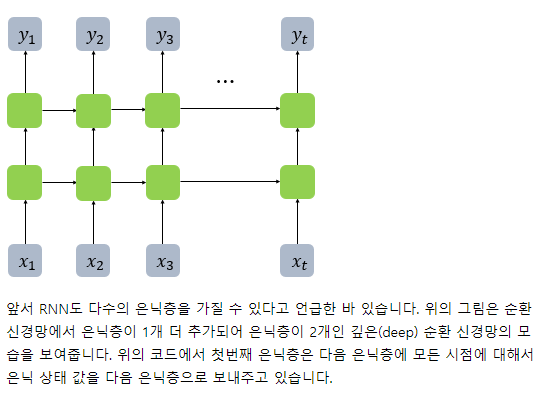

깊은 순환 신경망을 파이토치로 구현할 때는 nn.RNN()의 인자인 **num_layers**에 값을 전달하여 층을 쌓습니다. 층이 2개인 깊은 순환 신경망의 경우, 앞서 실습했던 임의의 입력에 대해서 출력이 어떻게 달라지는지 확인해봅시다.

In [15]:
# import urllib
# import time

# from urllib.request import urlopen
# from bs4 import BeautifulSoup

# stockCode = '065450' # 065450 빅텍

# trendOfInvestorUrl = 'http://finance.naver.com/item/frgn.nhn?code=' + stockCode
# trendOfInvestorHtml = urlopen(trendOfInvestorUrl)
# trendOfInvestorSource = BeautifulSoup(trendOfInvestorHtml.read(), "html.parser")

# trendOfInvestorPageNavigation = trendOfInvestorSource.find_all("table", align="center")
# trendOfInvestorMaxPageSection = trendOfInvestorPageNavigation[0].find_all("td", class_="pgRR")
# trendOfInvestorMaxPageNum = int(trendOfInvestorMaxPageSection[0].a.get('href')[-3:])

# for page in range(1, trendOfInvestorMaxPageNum + 1):
#     url = 'http://finance.naver.com/item/frgn.nhn?code=' + stockCode + '&page=' + str(page)
#     html = urlopen(url)
#     source = BeautifulSoup(html.read(), "html.parser")
#     dataSection = source.find("table", summary="외국인 기관 순매매 거래량에 관한표이며 날짜별로 정보를 제공합니다.")
#     dayDataList = dataSection.find_all("tr")

#     # day: 날짜
#     # institutionPureDealing: 기관순매매
#     # foreignerPureDealing: 외인순매매
#     # ownedVolumeByForeigner: 외인보유 주식수
#     # ownedRateByForeigner : 외인 보유율

#     for i in range(3, len(dayDataList)):

#         if(len(dayDataList[i].find_all("td", class_="tc")) != 0 and len(dayDataList[i].find_all("td", class_="num")) != 0):
#             day = dayDataList[i].find_all("td", class_="tc")[0].text
#             institutionPureDealing = dayDataList[i].find_all("td", class_="num")[4].text
#             foreignerPureDealing = dayDataList[i].find_all("td", class_="num")[5].text
#             ownedVolumeByForeigner = dayDataList[i].find_all("td", class_="num")[6].text
#             ownedRateByForeigner = dayDataList[i].find_all("td", class_="num")[7].text
#             print("날짜: " + day, end=" ")
#             print("기관순매매: " + institutionPureDealing, end=" ")
#             print("외인순매매: " + foreignerPureDealing, end=" ")
#             print("외인보유 주식수: " + ownedVolumeByForeigner, end=" ")
#             print("외인 보유율: " + ownedRateByForeigner)

In [16]:
# (batch_size, time_steps, input_size)
inputs =torch.Tensor(1,10,5) 

print(inputs)

tensor([[[1.5986e+34, 1.1626e+27, 8.9666e-33, 1.3563e-19, 1.8578e-01],
         [3.9125e-02, 4.7429e+30, 5.5272e+31, 7.5338e+28, 6.1687e+16],
         [1.4584e-19, 2.3308e-09, 1.1704e-19, 3.6408e-11, 1.3568e-19],
         [1.3563e-19, 1.3563e-19, 1.3563e-19, 1.3563e-19, 2.5346e-12],
         [1.4586e-19, 8.2990e-33, 1.3563e-19, 1.4754e-19, 1.3563e-19],
         [1.3563e-19, 1.3563e-19, 1.3563e-19, 5.1019e-08, 2.5740e-12],
         [3.1434e-12, 1.3563e-19, 3.9604e-11, 1.3563e-19, 1.3563e-19],
         [1.3563e-19, 1.3563e-19, 4.5071e+16, 9.3233e-09, 8.1572e+17],
         [1.3556e-19, 3.9592e-11, 1.3563e-19, 1.3563e-19, 1.3563e-19],
         [1.3563e-19, 1.3563e-19, 1.4587e-19, 3.7293e-08, 8.1546e-33]]])


In [17]:
cell = nn.RNN(input_size = 5, hidden_size = 8, num_layers =2,batch_first=True)
# RNN셀을 생성합니다. 입력의 크기 즉, 한번에 입력되는 크기는(변수의 갯수) 5, 
# 하나의 은닉층의 8개의 은닉셀, 이것이 2개의 층 


In [18]:
print(cell)

RNN(5, 8, num_layers=2, batch_first=True)


In [19]:
# 입력 텐서를 RNN 셀에 입력하여 출력을 확인해봅시다.
outputs, _status = cell(inputs)

In [20]:
print(outputs.shape)

torch.Size([1, 10, 8])


첫번째 리턴값의 크기는 층이 1개였던 RNN셀 때와 달라지지 않았습니다. 여기서는 마지막 층의 모든 시점의 은닉상태들입니다.

In [21]:
outputs

tensor([[[ 0.6495,  0.1619,  0.7665,  0.4743,  0.8714, -0.4596,  0.6936,
           0.4535],
         [-0.4190,  0.8094,  0.5839,  0.6279,  0.0322,  0.4183,  0.2744,
          -0.6246],
         [ 0.1729, -0.5118,  0.7691,  0.0769, -0.4583, -0.0919, -0.3524,
          -0.2790],
         [ 0.2147, -0.3859,  0.4818,  0.0549, -0.2901, -0.0584,  0.1013,
          -0.0235],
         [ 0.1444, -0.2537,  0.4366,  0.1550, -0.1620, -0.0220,  0.1682,
          -0.0907],
         [ 0.1096, -0.1839,  0.4645,  0.0726, -0.2114,  0.0239,  0.1727,
          -0.0609],
         [ 0.1197, -0.1976,  0.4383,  0.0905, -0.2057,  0.0439,  0.1465,
          -0.0989],
         [ 0.4280, -0.7957,  0.3080, -0.1404, -0.8979, -0.3927, -0.1385,
           0.2960],
         [-0.2047,  0.3961,  0.2042,  0.2136,  0.2544,  0.3304,  0.5386,
          -0.1195],
         [ 0.0893, -0.1299,  0.5685,  0.1093, -0.2369,  0.0367,  0.0732,
          -0.0745]]], grad_fn=<TransposeBackward1>)

In [23]:
print(_status.shape) #(층의 갯수, 배치의 크기, 은닉상태의 크기)
_status

torch.Size([2, 1, 8])


tensor([[[ 0.0565, -0.5548, -0.1175, -0.1956, -0.0859, -0.3832,  0.2670,
          -0.3124]],

        [[ 0.0893, -0.1299,  0.5685,  0.1093, -0.2369,  0.0367,  0.0732,
          -0.0745]]], grad_fn=<StackBackward>)

두번째 리턴값의 크기는 층이 1개였던 RNN셀 때와 달라졌는데, 여기서 크기는(층의 갯수, 배치크기, 은닉상태의 크기)에 해당됩니다. 

# 양방향 순환 신경망(Bidirectional Recurrent Neural Network) 

* 등장 배경 : t시점의 출력값을 예측할 때 이전 시점의 데이터 뿐만 아니라, 이후 데이터로도 예측할 수 있다는 아이디어에서 기반. 

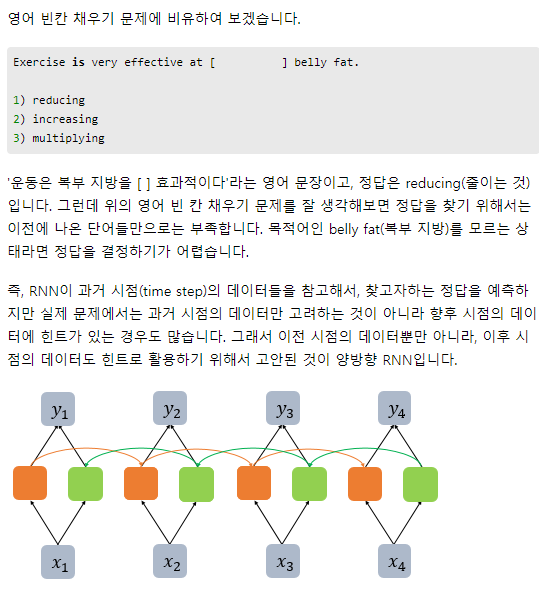

* 양방향 RNN은 하나의 출력값을 예측하기 위해 기본적으로 두개의 메모리셀을 사용한다.  
    1. 앞 시점의 은닉상태(Forward States)를 전달받아 현재의 은닉상태를 전달받아 현재의 은닉 상태를 계산합니다.  
    2. 뒤 시점의 은닉상태(Backward States)를 전달받아 현재의 은닉 상태를 계산합니다.  
    
    **이 두가지 값은 모두 출력층에서 출력값을 예측하기 위해 사용됩니다.**

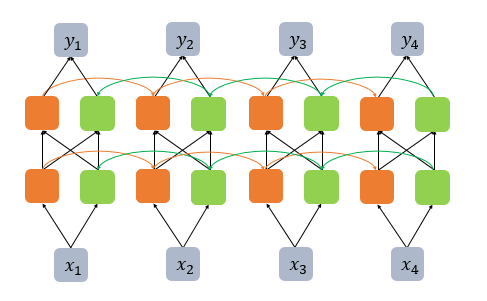
물론, 양방향 RNN도 다수의 은닉층을 가질 수 있다. 위의 그림은 양방향 순환 신경망에서 은닉층이 1개 더 추가되어 은닉층이 2개인 깊은(deep) 양방향 순환 신경망의 모습이다.



양방향 순환 신경망을 파이토치로 구현할 때는 nn.RNN()의 인자인 bidirectional에 값을 True로 전달하면 됩니다. 이번에는 층이 2개인 깊은 순환 신경망이면서 양방향인 경우, 앞서 실습했던 임의의 입력에 대해서 출력이 어떻게 달라지는지 확인해봅시다

In [24]:
# (batch_size, time_steps, input_size)
inputs = torch.Tensor(1, 10, 5) # 해당 크기의 임의의 텐서를 하나 만든다. 


In [25]:
# 양방향 RMM셀을 하나 생성한다. 
# 단순히 bidirectional = True 옵션을 이용해 기존의 단방향 RNN에서 양방향 RNN으로 바꿔줄 수 있다. 

cell = nn.RNN(input_size = 5, hidden_size = 8, num_layers = 2, batch_first=True, bidirectional = True)

In [26]:
outputs, _status = cell(inputs)


In [27]:
print(outputs.shape) # (배치 크기, 시퀀스 길이, 은닉 상태의 크기 x 2)

torch.Size([1, 10, 16])


첫번째 리턴값의 크기는 단뱡 RNN 셀 때보다 은닉 상태의 크기의 값이 두 배가 되었습니다. 여기서는 (배치 크기, 시퀀스 길이, 은닉 상태의 크기 x 2)의 크기를 가집니다. 이는 양방향의 은닉 상태 값들이 연결(concatenate)되었기 때문입니다.

In [28]:
print(_status.shape) # (층의 개수 x 2, 배치 크기, 은닉 상태의 크기)

torch.Size([4, 1, 8])


# 장단기 메모리(Long Short-Term Memory, LSTM)

cf) 바닐라 RNN = (가장 기본적인 모형의 RNN)

## 바닐라 RNN의 한계 

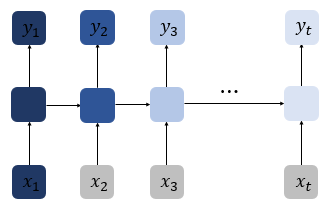
결과가 이전의 계산 결과에 의존한다는 것을 언급한 바 있습니다. 하지만 바닐라 RNN은 비교적 짧은 시퀀스(sequence)에 대해서만 효과를 보이는 단점이 있습니다. 바닐라 RNN의 시점(time step)이 길어질 수록 앞의 정보가 뒤로 충분히 전달되지 못하는 현상이 발생합니다. 위의 그림은 첫번째 입력값인 x1의 정보량을 짙은 남색으로 표현했을 때, 색이 점차 얕아지는 것으로 시점이 지날수록 x1의 정보량이 손실되어가는 과정을 표현하였습니다. 뒤로 갈수록 x1의 정보량은 손실되고, 시점이 충분히 긴 상황에서는 x1의 전체 정보에 대한 영향력은 거의 의미가 없을 수도 있습니다.

어쩌면 가장 중요한 정보가 시점의 앞 쪽에 위치할 수도 있습니다. RNN으로 만든 언어 모델이 다음 단어를 예측하는 과정을 생각해봅시다. 예를 들어 ''모스크바에 여행을 왔는데 건물도 예쁘고 먹을 것도 맛있었어. 그런데 글쎄 직장 상사한테 전화가 왔어. 어디냐고 묻더라구 그래서 나는 말했지. 저 여행왔는데요. 여기__ ' 다음 단어를 예측하기 위해서는 장소 정보가 필요합니다. 그런데 장소 정보에 해당되는 단어인 '모스크바'는 앞에 위치하고 있고, RNN이 충분한 기억력을 가지고 있지 못한다면 다음 단어를 엉뚱하게 예측합니다. 

이를 **장기 의존성 문제(the problem of Long-Term Dependencies)** 라고 합니다.

## 바닐라 RNN 내부 열어보기 
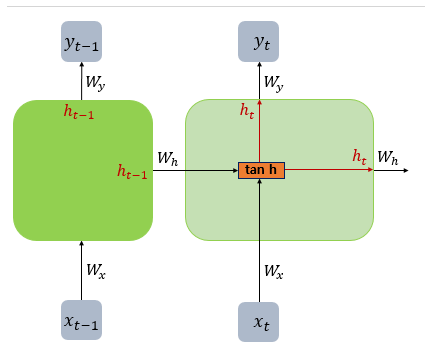

LSTM에 대해서 이해해보기 전에 바닐라 RNN의 뚜껑을 열어보겠습니다. 위의 그림은 바닐라 RNN의 내부 구조를 보여줍니다. 이 책에서는 RNN 계열의 인공 신경망의 그림에서는 편향 b를 생략합니다. 위의 그림에 편향 b를 그린다면 xt 옆에 tanh로 향하는 또 하나의 입력선을 그리면 됩니다.

h_t=tanh(W_x * x_t+W_h * h_t−1 + b)

바닐라 RNN은 xt와 ht−1이라는 두 개의 입력이 각각의 가중치와 곱해져서 메모리 셀의 입력이 됩니다. 그리고 이를 하이퍼볼릭탄젠트 함수의 입력으로 사용하고 이 값은 은닉층의 출력인 은닉 상태가 됩니다.

## LSTM(Long Short-Term Memory)

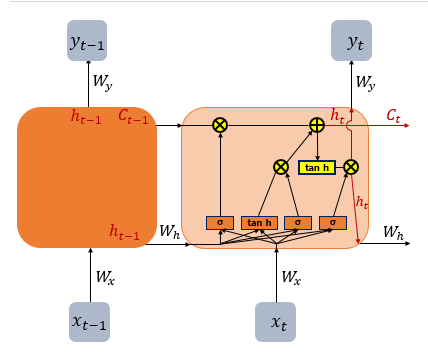
위의 그림은 LSTM의 전체적인 내부의 모습을 보여줍니다. 전통적인 RNN의 이러한 단점을 보완한 RNN의 일종을 **장단기 메모리(Long Short-Term Memory)** 라고 하며, 줄여서 **LSTM** 이라고 합니다. LSTM은 은닉층의 메모리 셀에 **입력 게이트, 망각 게이트, 출력 게이트**를 추가하여 불필요한 기억을 지우고, 기억해야할 것들을 정합니다. 요약하면 LSTM은 은닉 상태(hidden state)를 계산하는 식이 전통적인 RNN보다 조금 더 복잡해졌으며 셀 상태(cell state)라는 값을 추가하였습니다. 위의 그림에서는 t시점의 셀 상태를 Ct로 표현하고 있습니다. LSTM은 RNN과 비교하여 긴 시퀀스의 입력을 처리하는데 탁월한 성능을 보입니다.

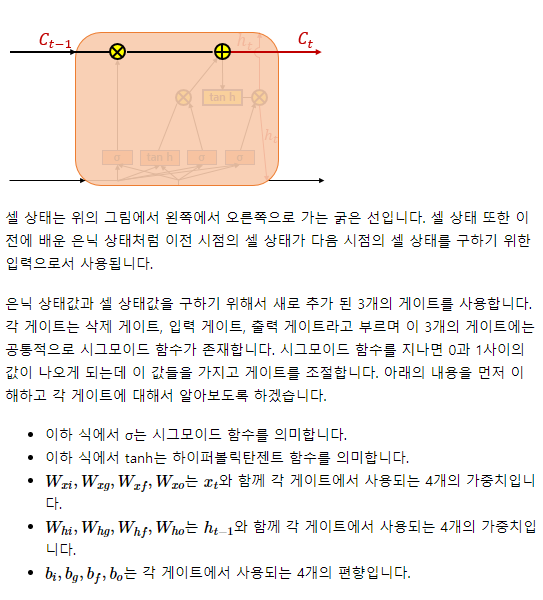

### 입력 게이트 

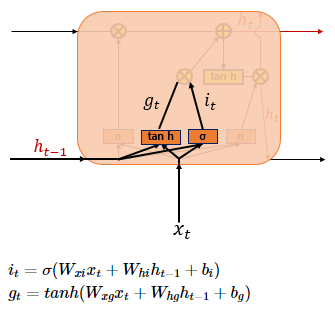

입력 게이트는 현재 정보를 기억하기 위한 게이트이다.  
  
  우선 현재 시점 t의 x값과 입력 게이트로 이어지는 가중치 Wxi를 곱한 값과 이전 시점 t-1의 은닉 상태가 입력 게이트로 이어지는 가중치 Whi를 곱한 값을 더하여 시그모이드 함수를 지납니다. 이를 it라고 합니다.  
    
그리고 현재 시점 t의 x값과 입력 게이트로 이어지는 가중치 Wxi를 곱한 값과 이전 시점 t-1의 은닉 상태가 입력 게이트로 이어지는 가중치 Whg를 곱한 값을 더하여 하이퍼볼릭탄젠트 함수를 지납니다. 이를 gt라고 합니다.  

시그모이드 함수를 지나 0과 1 사이의 값과 하이퍼볼릭탄젠트 함수를 지나 -1과 1사이의 값 두 개가 나오게 됩니다. 이 두 개의 값을 가지고 이번에 선택된 기억할 정보의 양을 정하는데, 구체적으로 어떻게 결정하는지는 아래에서 배우게 될 셀 상태 수식을 보면 됩니다.

### 삭제 게이트 
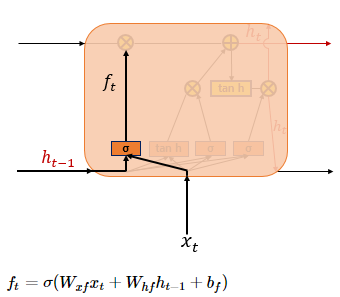
삭제 게이트는 기억을 삭제하기 위한 게이트입니다. 현재 시점 t의 x값과 이전 시점 t-1의 은닉 상태가 시그모이드 함수를 지나게 됩니다. 시그모이드 함수를 지나면 0과 1 사이의 값이 나오게 되는데, 이 값이 곧 삭제 과정을 거친 정보의 양입니다. 0에 가까울수록 정보가 많이 삭제된 것이고 1에 가까울수록 정보를 온전히 기억한 것입니다. 이를 가지고 셀 상태를 구하게 되는데, 구체적으로는 아래의 셀 상태 수식을 보면 됩니다.

### 셀 상태(장기 상태)
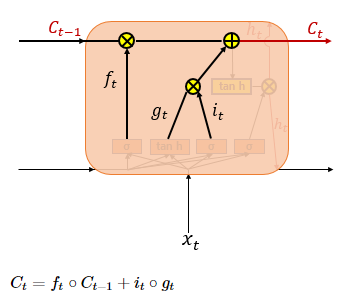

셀 상태 Ct를 LSTM에서는 장기 상태라고 부르기도 합니다. 그렇다면 셀 상태를 구하는 방법을 알아보겠습니다. 삭제 게이트에서 일부 기억을 잃은 상태입니다.

입력 게이트에서 구한 it, gt 이 두 개의 값에 대해서 원소별 곱(entrywise product)을 진행합니다. 다시 말해 같은 크기의 두 행렬이 있을 때 같은 위치의 성분끼리 곱하는 것을 말합니다. 여기서는 식으로 ∘ 로 표현합니다. 이것이 이번에 선택된 기억할 값입니다.

입력 게이트에서 선택된 기억을 삭제 게이트의 결과값과 더합니다. 이 값을 현재 시점 t의 셀 상태라고 하며, 이 값은 다음 t+1 시점의 LSTM 셀로 넘겨집니다.

삭제 게이트와 입력 게이트의 영향력을 이해해봅시다. 만약 삭제 게이트의 출력값인 ft가 0이 된다면, 이전 시점의 셀 상태값인 Ct−1은 현재 시점의 셀 상태값을 결정하기 위한 영향력이 0이 되면서, 오직 입력 게이트의 결과만이 현재 시점의 셀 상태값 Ct을 결정할 수 있습니다. 이는 삭제 게이트가 완전히 닫히고 입력 게이트를 연 상태를 의미합니다. 반대로 입력 게이트의 it값을 0이라고 한다면, 현재 시점의 셀 상태값 Ct는 오직 이전 시점의 셀 상태값 Ct−1의 값에만 의존합니다. 이는 입력 게이트를 완전히 닫고 삭제 게이트만을 연 상태를 의미합니다. 결과적으로 삭제 게이트는 이전 시점의 입력을 얼마나 반영할지를 의미하고, 입력 게이트는 현재 시점의 입력을 얼마나 반영할지를 결정합니다.

### 출력 게이트와 은닉 상태(단기 상태) 
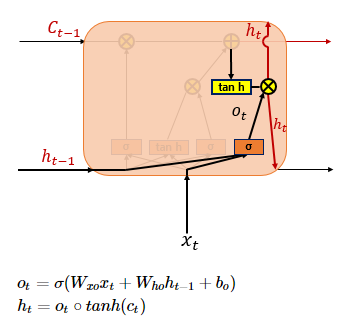
출력 게이트는 현재 시점 t의 x값과 이전 시점 t-1의 은닉 상태가 시그모이드 함수를 지난 값입니다. 해당 값은 현재 시점 t의 은닉 상태를 결정하는 일에 쓰이게 됩니다.

은닉 상태를 단기 상태라고 하기도 합니다. 은닉 상태는 장기 상태의 값이 하이퍼볼릭탄젠트 함수를 지나 -1과 1사이의 값입니다. 해당 값은 출력 게이트의 값과 연산되면서, 값이 걸러지는 효과가 발생합니다. 단기 상태의 값은 또한 출력층으로도 향합니다.

## 파이토치의 nn.LSTM

파이토치에서 LSTM 셀을 사용하는 방법은 매우 간단합니다. 기존에 RNN 셀을 사용하려고 했을 때는 다음과 같이 사용했었습니다.

$ nn.RNN(input_dim, hidden_size, batch_fisrt=True)  
LSTM 셀은 이와 유사하게 다음과 같이 사용합니다.

$ nn.LSTM(input_dim, hidden_size, batch_fisrt=True) 

In [30]:
import torch 
import torch.nn as nn 

input_size = 5 # 입력의 크기
hidden_size = 8 # 은닉 상태의 크기

#입력 텐서를 정의 
#입력 텐서는 (배치 크기 × 시점의 수 × 매 시점마다 들어가는 입력)의 크기를 가진다. 
# 여기서는 배치 크기는 1, 10번의 시점동안 5차원의 입력 벡터가 들어가도록 텐서를 정의합니다.

# (batch_size, time_steps, input_size)
inputs = torch.Tensor(1, 10, 5)

cell = nn.LSTM(input_size, hidden_size, batch_first=True)
# 아직 실질적인 데이터는 들어가지 않은 상태 
# 즉, 앞으로 들어갈 자료들의 크기 정보만을 준 상태로 초기화 

# 입력 텐서를 RNN 셀에 입력하여 출력을 확인해봅시다.
outputs, _status = cell(inputs)

print(outputs) # 모든 time-step의 hidden_state
print(_status) # 최종 time-step의 hidden_state

tensor([[[ 0.7616,  0.0000,  0.7616,  0.0000,  0.0000,  0.0000,  0.0000,
          -0.0000],
         [ 0.7616,  0.0000,  0.7616,  0.0000,  0.0000,  0.0000,  0.0000,
          -0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
          -0.0000],
         [ 0.0000,  0.0000, -0.0000,  0.0000, -0.7616,  0.0000,  0.0000,
           0.0000],
         [ 0.7616,  0.0000,  0.7616,  0.0000, -0.7616,  0.7616,  0.0000,
          -0.0000],
         [ 0.0000,  0.0000, -0.0000,  0.0000, -0.7616,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
          -0.0000],
         [ 0.0000,  0.7616, -0.0000,  0.0000,  0.7616,  0.0000, -0.0000,
          -0.0000],
         [-0.7616,  0.0000,  0.0000,  0.0000,  0.7616,  0.0000, -0.0000,
          -0.0000],
         [ 0.7616,  0.0000,  0.7616,  0.0000,  0.7616,  0.7616, -0.0000,
          -0.0000]]], grad_fn=<TransposeBackward0>)
(tensor([[[0.7616, 0.0000, 0.7616, 0.0

In [31]:
# 한개 층 더 쌓아보기 --> 깊은 LSTM 
import torch 
import torch.nn as nn 

input_size = 5 # 입력의 크기
hidden_size = 8 # 은닉 상태의 크기

#입력 텐서를 정의 
#입력 텐서는 (배치 크기 × 시점의 수 × 매 시점마다 들어가는 입력)의 크기를 가진다. 
# 여기서는 배치 크기는 1, 10번의 시점동안 5차원의 입력 벡터가 들어가도록 텐서를 정의합니다.

# (batch_size, time_steps, input_size)
inputs = torch.Tensor(1, 10, 5)

cell = nn.LSTM(input_size = 5, hidden_size = 8, num_layers =2,batch_first=True)
# 아직 실질적인 데이터는 들어가지 않은 상태 
# 즉, 앞으로 들어갈 자료들의 크기 정보만을 준 상태로 초기화 

# 입력 텐서를 RNN 셀에 입력하여 출력을 확인해봅시다.
outputs, _status = cell(inputs)

print(outputs) # 모든 time-step의 hidden_state
print(_status) # 최종 time-step의 hidden_state

tensor([[[ 0.0898, -0.1541,  0.0380,  0.0518, -0.1445, -0.0581, -0.1360,
          -0.0622],
         [ 0.0939, -0.1818,  0.1769, -0.0687, -0.1015, -0.0704, -0.2018,
           0.0380],
         [ 0.1480, -0.2512,  0.1411, -0.0009, -0.1647, -0.1066, -0.2808,
           0.0641],
         [ 0.1244, -0.2312,  0.2135, -0.0876, -0.1270, -0.0872, -0.2694,
           0.1335],
         [ 0.1604, -0.2739,  0.1468, -0.0053, -0.1769, -0.1099, -0.3043,
           0.1415],
         [ 0.1294, -0.2428,  0.2105, -0.0871, -0.1359, -0.0858, -0.2764,
           0.1817],
         [ 0.1616, -0.2777,  0.1405, -0.0026, -0.1811, -0.1079, -0.3040,
           0.1789],
         [ 0.1285, -0.2441,  0.2051, -0.0849, -0.1392, -0.0840, -0.2738,
           0.2043],
         [ 0.1603, -0.2774,  0.1356, -0.0005, -0.1825, -0.1065, -0.3013,
           0.1962],
         [ 0.1268, -0.2434,  0.2016, -0.0834, -0.1404, -0.0830, -0.2713,
           0.2147]]], grad_fn=<TransposeBackward0>)
(tensor([[[ 0.0000,  0.9999,  0.0000, 

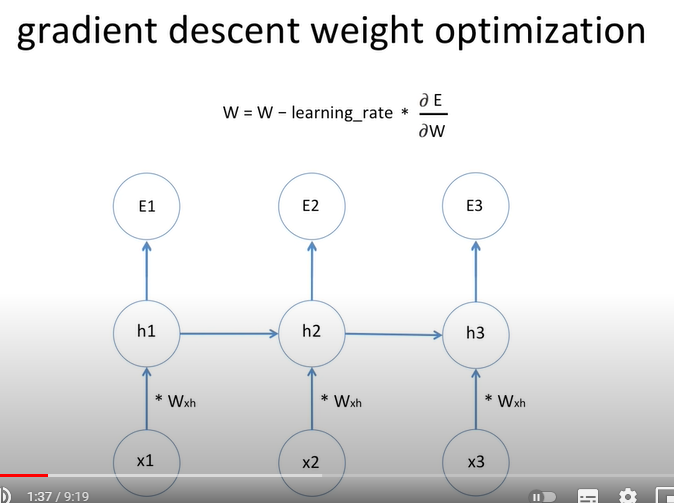
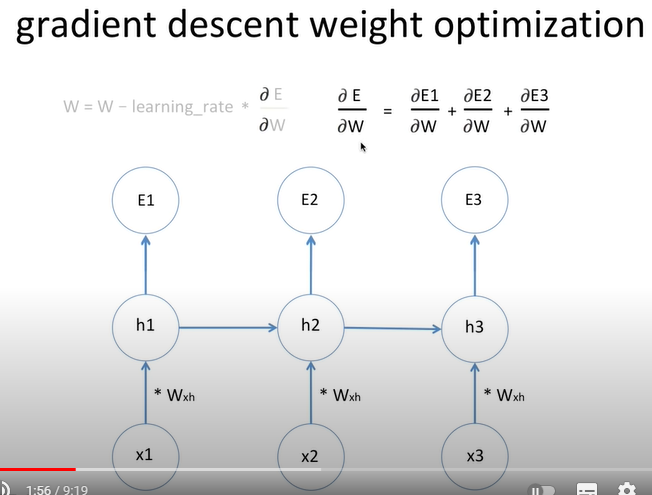
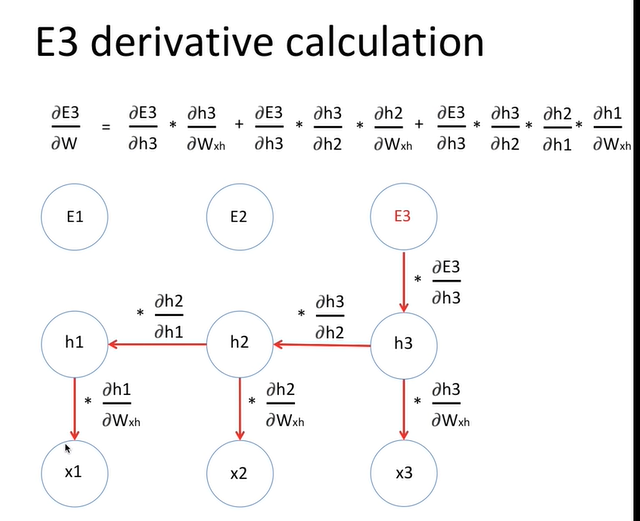
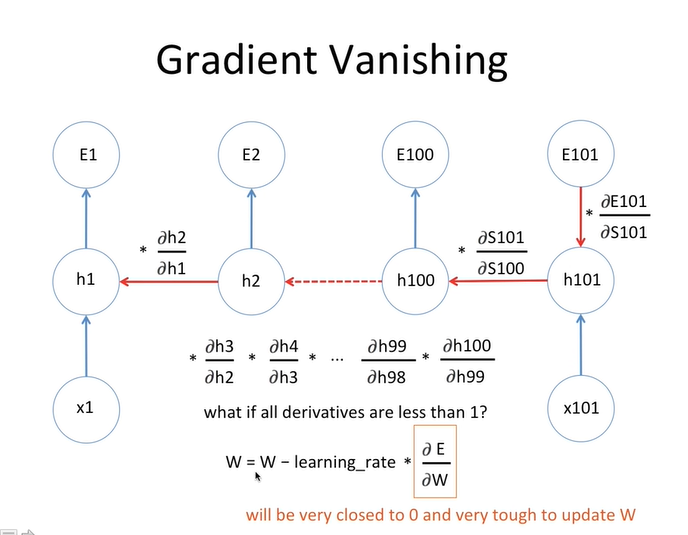
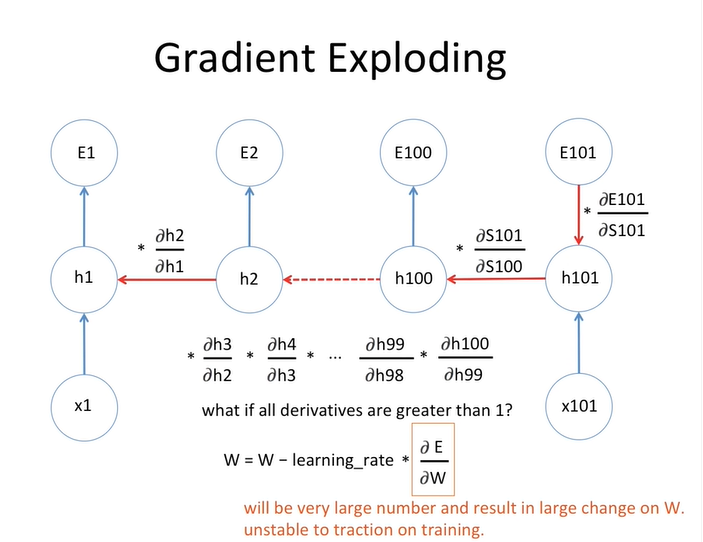

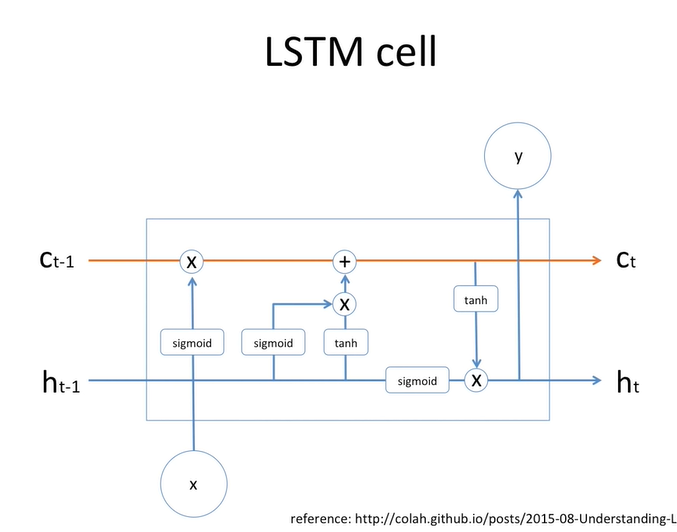
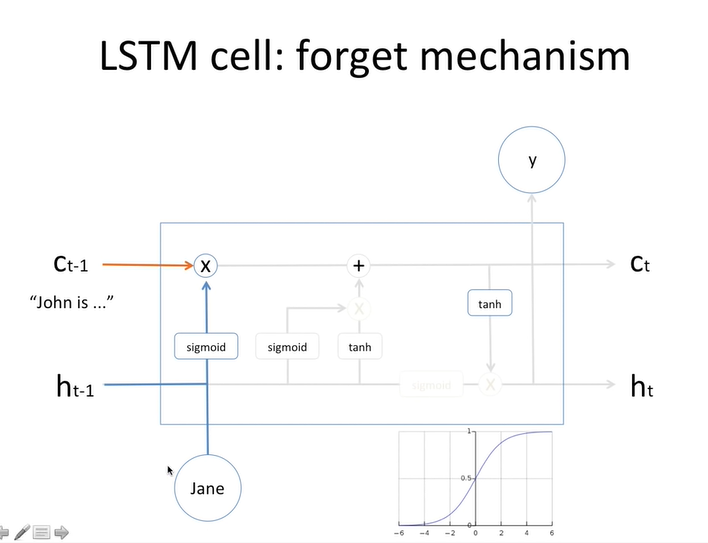
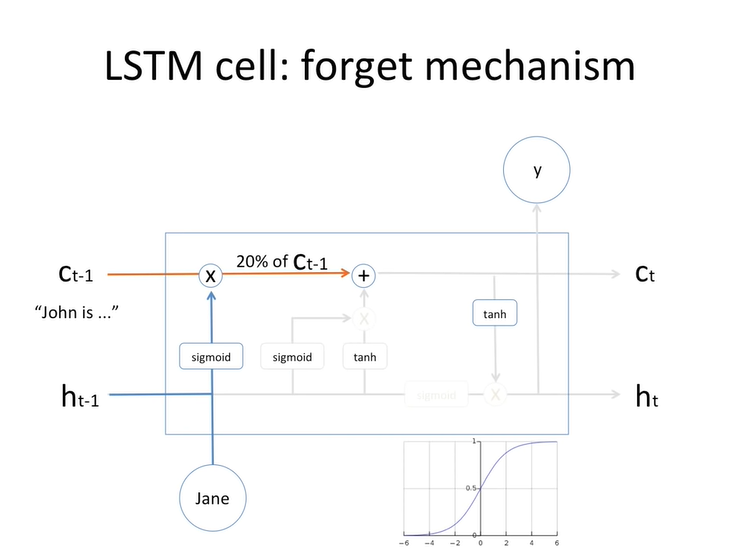
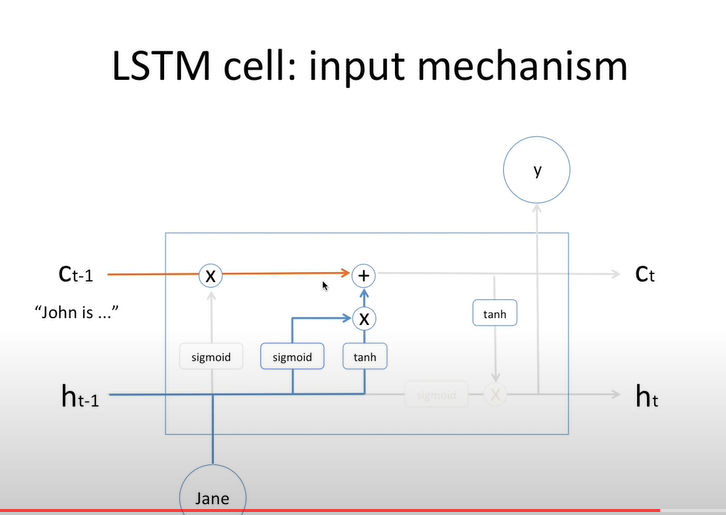
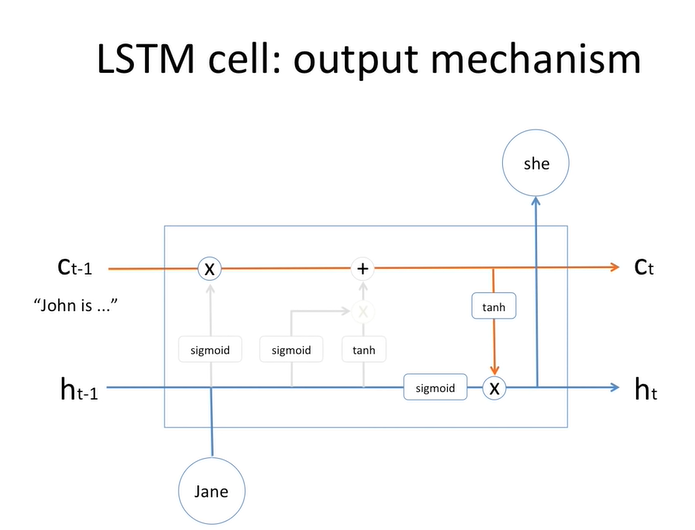